# Exploratory Data Analysis: preprocessing, data cleansing, statistical analysis and visualizations

### 1. import the necessary libraries for the analysis

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### 2. load data files and merge them into one DataFrame

Read college player statistics from 2009 to 2022. The data can be found in two different csv files, one contains stats from 2009 to 2021, while the other one contains the latest statistics (2022).

In [133]:
college1 = pd.read_csv('Data\CollegeBasketballPlayers2009-2021.csv',low_memory=False)
college2 = pd.read_csv('Data\CollegeBasketballPlayers2022.csv',low_memory=False)

The other data source contains draft picks at the nba draft for each year from 2009 to 2021.

In [134]:
draft = pd.read_excel('Data\DraftedPlayers2009-2021.xlsx')

First of all, lets concatenate the college statistical dataframes.

In [135]:
college = pd.concat([college1,college2])
print(college1.size+college2.size == college.size)

True


Since the draft data set has merged cells in the table header the first row must be dropped.

In [136]:
draft.drop(0,axis=0,inplace=True)

Rename the ROUND.1 column to PICK, and modify the PLAYER to player_name, so it can be act as a key during the join with the college data set.

In [137]:
draft.rename(
    columns={
        "PLAYER": "player_name", 
        "TEAM": "drafted_by", 
        "YEAR" : "year", 
        "ROUND" : "draft_round", 
        "ROUND.1" : "pick_no",
        "OVERALL" : "draft_pick"},
        inplace=True)

Convert all column names to lowcase letters.

In [138]:
draft.columns = draft.columns.str.lower()

Merge the college set with the draft data to identify those players who have been drafted after playing in college.

In [139]:
df = pd.merge(college,draft,how='outer',on=['player_name','year'])

### 3. clean the data set and prepare it for statistical analyzis and further analytical steps

Create a new column to identify the drafted players.

In [140]:
df['drafted_flag'] = (~df.draft_pick.isnull())*1

Since the draft data does not contain information about 2022, rows for 2022 should removed from the 'df' data set and saved into a new dataframe.

In [141]:
df_2022 = df[df.year == 2022]
df = df[df.year < 2022]

Rename unnamed column 64 for clearity.

In [142]:
df.rename(columns={'Unnamed: 64':'player_position'},inplace=True)

Drop unknown, irrelevant (not statistical, such as 'num': jersey number column) or dupplicate columns.

In [143]:
print(df.isnull().sum().sort_values(ascending=False))

affiliation     60461
draft_round     60459
draft_pick      60459
drafted_by      60459
pick_no         60459
                ...  
twoPA             193
eFG               193
player_name         0
year                0
drafted_flag        0
Length: 72, dtype: int64


In [144]:
# unknown with nan values
df = df.drop('Unnamed: 65', axis=1)
# irrelevant, not statistical data (jersey number)
df = df.drop('num', axis=1)
# irrelevant, not statistical data (player id in the database)
df = df.drop('pid', axis=1)
# irrelevant, not statistical data (unique value for all rows)
df = df.drop('type', axis=1)
# irrelevant, the information is included in the draft_pick column
df = df.drop('pick_no', axis=1)
# irrelevant, the information is included in the draft_pick column
df = df.drop('pick', axis=1)

Handle missing values.

In [145]:
df.drafted_flag.fillna(value=0, inplace=True)
df.yr.fillna(value='None', inplace=True)
df.player_position.fillna(value='None', inplace=True)

Check non integer columns and find the categorical values.

In [146]:
df_nonint = df.select_dtypes(exclude=['int64','float'])
df_nonint.columns

Index(['player_name', 'team', 'conf', 'yr', 'ht', 'player_position',
       'drafted_by', 'affiliation', 'draft_round', 'draft_pick',
       'drafted_flag'],
      dtype='object')

In [147]:
df_nonint.nunique()

player_name        25902
team                 362
conf                  36
yr                     8
ht                    39
player_position        9
drafted_by            34
affiliation          231
draft_round            2
draft_pick            60
drafted_flag           2
dtype: int64

Check distinct values for object type 'yr' column.

In [148]:
print(df.yr.value_counts())

Jr      16241
Fr      16233
So      14485
Sr      13801
None      487
0           5
57.1        1
42.9        1
Name: yr, dtype: int64


Handle mistyped or wrong values.

In [149]:
df.yr.replace('0', 'None', inplace=True)
df.yr.replace('57.1', 'None', inplace=True)
df.yr.replace('42.9', 'None', inplace=True)

One hot encode categorical column: yr

In [150]:
df = pd.get_dummies(df, columns=['yr'])

Reorder columns to have drafted_flag as the last column of the dataframe.

In [152]:
col_list = df.columns.tolist()
print(col_list)
col_list.pop(-7)  # 'draft_pick'
col_list.append('draft_pick')
df = df[col_list]
print(df.columns.tolist())

['player_name', 'team', 'conf', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'ht', 'porpag', 'adjoe', 'pfr', 'year', 'Rec Rank', 'ast/tov', 'rimmade', 'rimmade+rimmiss', 'midmade', 'midmade+midmiss', 'rimmade/(rimmade+rimmiss)', 'midmade/(midmade+midmiss)', 'dunksmade', 'dunksmiss+dunksmade', 'dunksmade/(dunksmade+dunksmiss)', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts', 'player_position', 'drafted_by', 'affiliation', 'draft_round', 'draft_pick', 'drafted_flag', 'yr_Fr', 'yr_Jr', 'yr_None', 'yr_So', 'yr_Sr']
['player_name', 'team', 'conf', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'h

Check non-numeric columns.

In [154]:
print(df.dtypes.value_counts())
print(df.select_dtypes('object').columns)

float64    55
object      9
uint8       5
int32       1
dtype: int64
Index(['player_name', 'team', 'conf', 'ht', 'player_position', 'drafted_by',
       'affiliation', 'draft_round', 'draft_pick'],
      dtype='object')


Check target feature 'Overall' column values.

In [155]:
df.draft_pick.fillna(value=0, inplace=True)
print(df.draft_pick.unique())

[ 0  8 44 20 14 33 32 50 40 13 46 58 59 26 51 37 35 19 16  7 12 54  6 11
 38 21 18 28 27 36  2 15 60  1 56 43 45 29  3 48 41 17  9  4 55 31 24 57
 30 39 25 23 42 52 34 10 47 22  5 53 49]


Check pick and round columns.

In [156]:
df.draft_round.fillna(value=0, inplace=True)
print(df.draft_round.unique())

[0 1 2]


Leave only numeric data and fill all remaining columns with zeros.

In [157]:
df = df.select_dtypes(exclude='object')
df.fillna(value=0, inplace=True)

Check data for the drafted_flag column.

In [158]:
print(df.groupby(['year','draft_pick'])['draft_pick'].count())

year    draft_pick
2009.0  0             4542
        1                1
        2                1
        3                1
        4                1
                      ... 
2021.0  56               1
        57               1
        58               1
        59               1
        60               1
Name: draft_pick, Length: 793, dtype: int64


### 4. create visualizations and analyze statistics

Calculate basic statistics.

In [159]:
df.describe()

,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,blk,pts,draft_round,drafted_flag,yr_Fr,yr_Jr,yr_None,yr_So,yr_Sr,draft_pick
count,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000,...,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000,61254.000000
mean,22.725928,37.011405,91.377572,18.069228,44.360554,47.434283,5.524787,12.664213,10.774643,20.162128,...,0.279936,5.751806,0.019395,0.012979,0.265011,0.265142,0.008065,0.236474,0.225308,0.393803
std,10.230870,28.090986,31.338865,6.325983,18.570930,17.813551,9.296129,10.761744,9.367549,12.351467,...,0.414460,4.951196,0.178468,0.113184,0.441343,0.441412,0.089442,0.424920,0.417788,3.960613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,9.000000,83.700000,14.500000,40.000000,43.700000,1.700000,8.400000,4.600000,14.600000,...,0.000000,1.551700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,35.500000,97.050000,18.100000,47.700000,50.830000,4.300000,11.900000,9.000000,19.000000,...,0.133300,4.454500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,61.900000,106.900000,21.800000,53.300000,56.090000,8.100000,16.100000,15.000000,24.400000,...,0.363600,9.035700,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,98.000000,834.000000,50.000000,150.000000,150.000000,1576.600000,1385.000000,100.000000,100.000000,...,5.258100,30.090900,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.000000


Create correlation matrix.

In [160]:
corr_matrix = df.corr()
corr_matrix = corr_matrix[abs(corr_matrix) < 1]
corr_matrix = corr_matrix.stack().reset_index()
corr_matrix.columns = ['Variable1','Variable2','Correlation']
print(corr_matrix)

       Variable1 Variable2  Correlation
0             GP   Min_per     0.767260
1             GP      Ortg     0.447655
2             GP       usg     0.210187
3             GP       eFG     0.420294
4             GP    TS_per     0.438828
...          ...       ...          ...
3901  draft_pick     yr_Fr    -0.034815
3902  draft_pick     yr_Jr    -0.024464
3903  draft_pick   yr_None     0.288105
3904  draft_pick     yr_So    -0.020684
3905  draft_pick     yr_Sr     0.021983

[3906 rows x 3 columns]


In [163]:
corr_matrix[corr_matrix.Variable1 == 'draft_pick'].sort_values(by='Correlation')

,Variable1,Variable2,Correlation
3882,draft_pick,adrtg,-0.276538
3881,draft_pick,drtg,-0.267815
3853,draft_pick,TO_per,-0.065715
3868,draft_pick,pfr,-0.044795
3901,draft_pick,yr_Fr,-0.034815
...,...,...,...
3878,draft_pick,dunksmade,0.135634
3866,draft_pick,porpag,0.163103
3903,draft_pick,yr_None,0.288105
3900,draft_pick,drafted_flag,0.867095


Calculate the empirical distribution of the target feature per year.

In [165]:
drafted_per_year = df[df.draft_pick > 1].groupby('year').count()['draft_pick']
count_per_year = df.groupby('year').count()['GP']
yearly_drafts = drafted_per_year/count_per_year
print(yearly_drafts)

year
2009.0    0.013035
2010.0    0.012750
2011.0    0.013582
2012.0    0.013055
2013.0    0.012754
2014.0    0.012658
2015.0    0.012653
2016.0    0.012511
2017.0    0.013031
2018.0    0.012497
2019.0    0.012416
2020.0    0.012642
2021.0    0.012442
dtype: float64


Plot the heatmap of the correlations.

<Axes: >

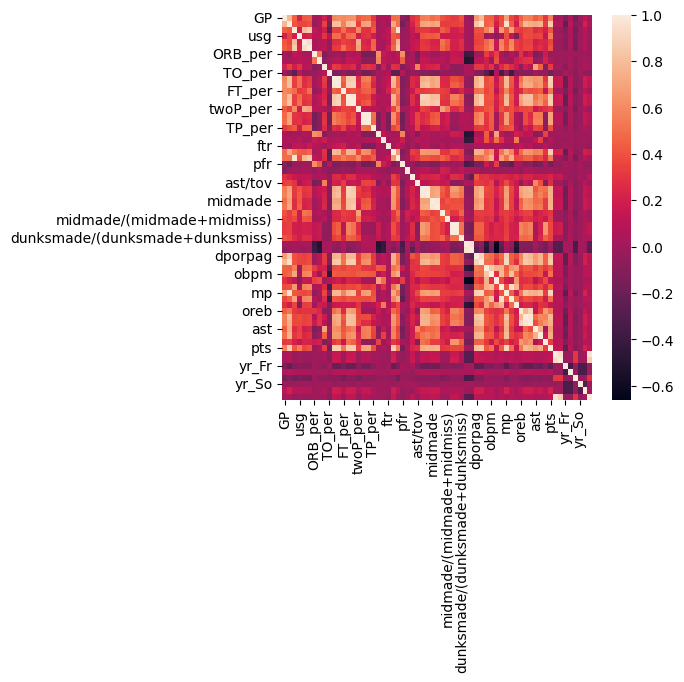

In [166]:
# plot settings
plt.rcParams['figure.figsize']=(5,5)

# heatmap of the correlations
sns.heatmap(df.corr(),annot=False)

Plot the histogram of the target feature.

<Axes: xlabel='draft_pick', ylabel='Count'>

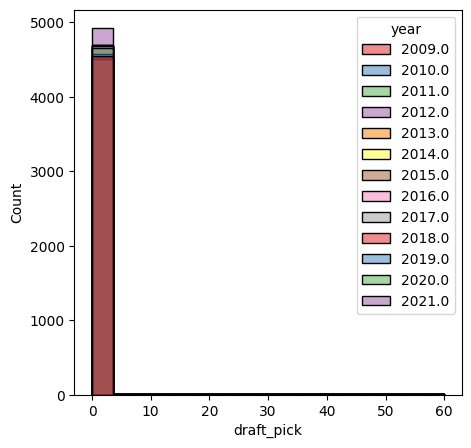

In [167]:
sns.histplot(data=df, x="draft_pick", hue="year",palette="Set1")

Check the ratio of the target feature labels.

In [168]:
df.draft_pick.value_counts()

0     60459
20       17
4        15
59       14
30       14
      ...  
32       13
60       13
1        13
56       13
49       13
Name: draft_pick, Length: 61, dtype: int64

Check the correlations with the highest absolute value between the target feature and the predictors.

In [169]:
drafted_corr_matrix = corr_matrix[corr_matrix.Variable1 == 'draft_pick'].sort_values(by='Correlation',ascending=False)
print(drafted_corr_matrix.sort_values(by='Correlation',ascending=False))

       Variable1     Variable2  Correlation
3899  draft_pick   draft_round     0.959463
3900  draft_pick  drafted_flag     0.867095
3903  draft_pick       yr_None     0.288105
3866  draft_pick        porpag     0.163103
3878  draft_pick     dunksmade     0.135634
...          ...           ...          ...
3901  draft_pick         yr_Fr    -0.034815
3868  draft_pick           pfr    -0.044795
3853  draft_pick        TO_per    -0.065715
3881  draft_pick          drtg    -0.267815
3882  draft_pick         adrtg    -0.276538

[62 rows x 3 columns]


In [171]:
df[df.draft_pick > 0]

,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,blk,pts,draft_round,drafted_flag,yr_Fr,yr_Jr,yr_None,yr_So,yr_Sr,draft_pick
114,34.0,86.3,108.9,28.0,53.7,56.04,15.4,22.2,9.6,17.5,...,1.7059,18.2647,1,1,0,1,0,0,0,8
115,35.0,93.7,117.5,23.9,55.4,59.42,4.9,14.8,19.0,16.6,...,0.4571,18.0000,2,1,0,1,0,0,0,44
154,34.0,88.0,117.3,32.6,52.4,58.33,1.6,10.0,40.8,15.4,...,0.1765,22.3529,1,1,0,0,0,0,1,20
192,37.0,85.4,100.3,24.6,49.2,51.67,9.1,18.7,18.2,22.0,...,1.3784,14.1892,1,1,0,1,0,0,0,14
234,38.0,78.6,109.0,24.7,52.5,55.68,9.5,17.0,8.8,15.8,...,1.2368,16.1053,2,1,0,0,0,0,1,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65227,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0000,0.0000,2,1,0,0,1,0,0,47
65228,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0000,0.0000,2,1,0,0,1,0,0,49
65229,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0000,0.0000,2,1,0,0,1,0,0,52
65230,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0000,0.0000,2,1,0,0,1,0,0,53


### 5. Random model creation

Use the empirical distribution of the drafted flag feature to create a random model predicting the drafted players (Bernoulli distribution).

In [31]:
from scipy.stats import bernoulli

# probability of drafted flag = 1
prob_drafted = np.average(yearly_drafts)

# random model with the given Bernoulli distribution with the length of
rand_model = pd.DataFrame(data=[bernoulli(prob_drafted).rvs(len(df))])
rand_model = rand_model.transpose()
rand_model.columns = ['pred_drafted_flag']

print(rand_model.value_counts())

pred_drafted_flag
0                    60509
1                      552
dtype: int64


### 6. Random model evaluation

In [32]:
# evaluate the random model
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_pred=rand_model.pred_drafted_flag, y_true=df.drafted_flag)
cp = classification_report(y_pred=rand_model.pred_drafted_flag, y_true=df.drafted_flag)
print(cm, cp, sep='\n')

[[59912   547]
 [  597     5]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     60459
           1       0.01      0.01      0.01       602

    accuracy                           0.98     61061
   macro avg       0.50      0.50      0.50     61061
weighted avg       0.98      0.98      0.98     61061

